# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from affine import Affine
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from xhistogram.xarray import histogram
from rasterio import features
import zarr
import rioxarray
import regionmask
import gcsfs
import s3fs
from geocube.api.core import make_geocube
import shapely.wkb 
from shapely.ops import cascaded_union
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tqdm import tqdm
from ast import literal_eval

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

In [4]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(n_workers=1, threads_per_worker=36)
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

2023-03-03 13:47:53,824 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d2shhm_w', purging
2023-03-03 13:47:53,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ksu0gnct', purging
2023-03-03 13:47:53,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kqykwbxj', purging
2023-03-03 13:47:53,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wxa45z45', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40581,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:45763,Total threads: 4
Dashboard: http://127.0.0.1:42911/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:43035,


<a id='utils'></a>
### Utils

**intersect_areas**

In [5]:
def intersect_areas(gdf, geometry):
    """
    Intersection between the areas of a GeoDataFrame and a geometry
    """
    sindex = gdf.sindex
    
    # Areas that intersect with the geometry
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    
    # Intersection between the areas and the geometry
    precise_matches = possible_matches.intersection(geometry)
    
    # Replace areas with the intersected ones
    final_matches = possible_matches[~precise_matches.is_empty]
    final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])
    
    return final_matches

**plot_hist**

In [6]:
def plot_hist(x_min, count):
    width = x_min[1]-x_min[0]
    width -= width/5.
    x_min += width/(5.*2)
    per = count/count.sum()*100
    
    plt.figure(figsize=(10,5))
    
    plt.bar(x_min, per, width=width)
    
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
    plt.title('Soil Organic Carbon Stock')
    plt.xlabel('SOC stock t C/ha)')
    plt.ylabel('(%) of total area')

**read_dataset_from_zarr**

In [7]:
def read_dataset_from_zarr(s3_path, group):
    # Initilize the S3 file system
    s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    # Read Zarr file
    ds = xr.open_zarr(store=store, group=group, consolidated=True)
    
    # Change coordinates names
    ds = ds.rename({'x': 'lon', 'y': 'lat'})
    
    # Change dimension name
    if group == 'concentration':
        ds = ds.rename({'depht': 'depth'})
    
    return ds

**read_dataset_from_zarr_local**

In [8]:
def read_dataset_from_zarr_local(path, group):
    # Read Zarr file
    ds = xr.open_zarr(store=path, group=group, consolidated=True)
    
    # Change coordinates names
    ds = ds.rename({'x': 'lon', 'y': 'lat'})
    
    return ds

**prepare_vector_data**

In [9]:
def prepare_vector_data(iso=None, tolerance=None):
    if iso:
        bboxs = pd.read_csv('../data/mbtiles/country_bbox.csv', converters={"bbox": literal_eval})
        bbox = bboxs[bboxs['gid_0'] == iso].bbox.iloc[0]
    else:
        bbox = None
        
    # Read Political boundaries:
    print('Reading Political boundaries')
    gdf_pb = gpd.read_file('../data/mbtiles/political_boundaries/political_boundaries.shp', bbox = bbox)
    # Select up to level 1 admin areas
    gdf_pb = gdf_pb[gdf_pb['level'] <= 1]
    #Simplify geometries
    if tolerance:
        gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.simplify(tolerance)) 
    # Add area in ha
    gdf_pb['area_ha'] = gdf_pb['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)    
    gdf_pb = gdf_pb[['name_0', 'gid_0', 'name_1', 'gid_1', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    
    # Read Landforms
    print('Reading Landforms')
    gdf_land = gpd.read_file('../data/mbtiles/ne_10m_geography_regions/ne_10m_geography_regions.shp', bbox = bbox)
    # Add area in ha
    gdf_land = gdf_land.set_crs(epsg=4326, allow_override=True)
    gdf_land = gdf_land.to_crs("EPSG:4326")
    gdf_land['area_ha'] = gdf_land['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)   
    gdf_land = gdf_land[['featurecla', 'name', 'region', 'ne_id', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    
    # Read Biomes
    print('Reading Biomes')
    gdf_bio = gpd.read_file('../data/mbtiles/ecoregions_by_biome/ecoregions_by_biome.shp', bbox = bbox)
    # Add area in ha
    gdf_bio = gdf_bio.set_crs(epsg=4326, allow_override=True)
    gdf_bio = gdf_bio.to_crs("EPSG:4326")
    gdf_bio['area_ha'] = gdf_bio['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4) 
    gdf_bio = gdf_bio[['biome_name', 'biome_num', 'eco_name', 'eco_biome_', 'eco_id', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    
    # Read Hydrological basins
    print('Reading Hydrological basins')
    gdf_hb = gpd.read_file('../data/mbtiles/hydrological_basins/hydrological_basins.shp', bbox = bbox)
    #Make valid geometries
    gdf_hb['geometry'] = gdf_hb['geometry'].apply(lambda x: x.buffer(0))
    # Add area in ha
    gdf_hb = gdf_hb.set_crs(epsg=4326, allow_override=True)
    gdf_hb = gdf_hb.to_crs("EPSG:4326")
    gdf_hb['area_ha'] = gdf_hb['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4) 
    gdf_hb = gdf_hb[['maj_bas', 'maj_name', 'maj_area', 'sub_bas', 'sub_name', 'sub_area', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]

    vector_data = {'political_boundaries': gdf_pb, 'landforms': gdf_land, 'biomes': gdf_bio, 'hydrological_basins': gdf_hb}
    
    if iso:
        print('Intersecting areas with the selected country')
        gdf_pb = gdf_pb[gdf_pb['gid_0'] == iso]
            
        vector_data['political_boundaries'] = gdf_pb
        
        country = gdf_pb[gdf_pb['level'] == 0]['geometry'].iloc[0].buffer(0)
        
        for data_name in list(vector_data.keys())[1:]:
            print(data_name)
            vector_data[data_name] = intersect_areas(vector_data[data_name], country)
            
    # Split DataFrames to avoid overlapping geometries
    split_df_by = ['level', 'level', 'level', 'level']
    print("splitting DataFrames")
    for n, data_name in enumerate(list(vector_data.keys())):
        if split_df_by[n]:
            df = vector_data[data_name].copy()
            del vector_data[data_name]
            categories = list(df[split_df_by[n]].unique())
            for category in categories:
                vector_data[data_name+'_'+str(category)] = df[df[split_df_by[n]] == category]    
            
    # Further split DataFrames landforms_1
    df = vector_data['landforms_1'].copy()
    del vector_data['landforms_1']
    categories = list(df['featurecla'].unique())
    for category in categories:
        vector_data['landforms_1'+'_'+str(category)] = df[df['featurecla'] == category] 
                
    # Set index
    for data_name in list(vector_data.keys()):
        vector_data[data_name] = vector_data[data_name].reset_index(drop=True).reset_index()
   
    return vector_data

**prepare_vector_data_political_boundaries**

In [10]:
def prepare_vector_data_political_boundaries(iso=None, tolerance=None):
    if iso:
        bboxs = pd.read_csv('../data/mbtiles/country_bbox.csv', converters={"bbox": literal_eval})
        bbox = bboxs[bboxs['gid_0'] == iso].bbox.iloc[0]
    else:
        bbox = None
        
    # Read Political boundaries:
    print('Reading Political boundaries')
    gdf_pb = gpd.read_file('../data/mbtiles/political_boundaries/political_boundaries.shp', bbox = bbox)
    # Select up to level 1 admin areas
    gdf_pb = gdf_pb[gdf_pb['level'] <= 1]
    #Simplify geometries
    if tolerance:
        gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.simplify(tolerance)) 
    # Add area in ha
    gdf_pb['area_ha'] = gdf_pb['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)    
    gdf_pb = gdf_pb[['name_0', 'gid_0', 'name_1', 'gid_1', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    

    vector_data = {'political_boundaries': gdf_pb}
    
    if iso:
        print('Intersecting areas with the selected country')
        gdf_pb = gdf_pb[gdf_pb['gid_0'] == iso]
            
        vector_data['political_boundaries'] = gdf_pb
        
        country = gdf_pb[gdf_pb['level'] == 0]['geometry'].iloc[0].buffer(0)
        
            
    # Split DataFrames to avoid overlapping geometries
    split_df_by = ['level', 'level', 'level', 'level']
    print("splitting DataFrames")
    for n, data_name in enumerate(list(vector_data.keys())):
        if split_df_by[n]:
            df = vector_data[data_name].copy()
            del vector_data[data_name]
            categories = list(df[split_df_by[n]].unique())
            for category in categories:
                vector_data[data_name+'_'+str(category)] = df[df[split_df_by[n]] == category]    

    # Set index
    for data_name in list(vector_data.keys()):
        vector_data[data_name] = vector_data[data_name].reset_index(drop=True).reset_index()
   
    return vector_data

**prepare_vector_data_level**

In [11]:
def prepare_vector_data_level(iso=None, tolerance=None, level=1):
    if iso:
        bboxs = pd.read_csv('../data/mbtiles/country_bbox.csv', converters={"bbox": literal_eval})
        bbox = bboxs[bboxs['gid_0'] == iso].bbox.iloc[0]
    else:
        bbox = None
        
    # Read Political boundaries:
    print('Reading Political boundaries')
    gdf_pb = gpd.read_file('../data/mbtiles/political_boundaries/political_boundaries.shp', bbox = bbox)
    # Select level 0 areas
    gdf_pb_0 = gdf_pb[gdf_pb['level'] == 0]
    # Select level 1 areas
    gdf_pb = gdf_pb[gdf_pb['level'] == level]
    #Simplify geometries
    if tolerance:
        gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.simplify(tolerance)) 
    # Add area in ha
    gdf_pb['area_ha'] = gdf_pb['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)    
    gdf_pb = gdf_pb[['name_0', 'gid_0', 'name_1', 'gid_1', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    
    # Read Landforms
    print('Reading Landforms')
    gdf_land = gpd.read_file('../data/mbtiles/ne_10m_geography_regions/ne_10m_geography_regions.shp', bbox = bbox)
    # Select level 1 areas
    gdf_land = gdf_land[gdf_land['level'] == level]
    # Add area in ha
    gdf_land = gdf_land.set_crs(epsg=4326, allow_override=True)
    gdf_land = gdf_land.to_crs("EPSG:4326")
    if iso == None:
        gdf_land['area_ha'] = gdf_land['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)   
        gdf_land = gdf_land[['featurecla', 'name', 'region', 'ne_id', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    else:
        gdf_land = gdf_land[['featurecla', 'name', 'region', 'ne_id', 'level', 'bbox', 'id', 'id_0', 'geometry']]
    
    # Read Biomes
    print('Reading Biomes')
    gdf_bio = gpd.read_file('../data/mbtiles/ecoregions_by_biome/ecoregions_by_biome.shp', bbox = bbox)
    # Select level 1 areas
    gdf_bio = gdf_bio[gdf_bio['level'] == level]    
    # Add area in ha
    gdf_bio = gdf_bio.set_crs(epsg=4326, allow_override=True)
    gdf_bio = gdf_bio.to_crs("EPSG:4326")
    if iso == None:
        gdf_bio['area_ha'] = gdf_bio['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4) 
        gdf_bio = gdf_bio[['biome_name', 'biome_num', 'eco_name', 'eco_biome_', 'eco_id', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    else:
        gdf_bio = gdf_bio[['biome_name', 'biome_num', 'eco_name', 'eco_biome_', 'eco_id', 'level', 'bbox', 'id', 'id_0', 'geometry']]
    
    # Read Hydrological basins
    print('Reading Hydrological basins')
    gdf_hb = gpd.read_file('../data/mbtiles/hydrological_basins/hydrological_basins.shp', bbox = bbox)
    # Select level 1 areas
    gdf_hb = gdf_hb[gdf_hb['level'] == level]    
    #Make valid geometries
    gdf_hb['geometry'] = gdf_hb['geometry'].apply(lambda x: x.buffer(0))
    # Add area in ha
    gdf_hb = gdf_hb.set_crs(epsg=4326, allow_override=True)
    gdf_hb = gdf_hb.to_crs("EPSG:4326")
    if iso == None:
        gdf_hb['area_ha'] = gdf_hb['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4) 
        gdf_hb = gdf_hb[['maj_bas', 'maj_name', 'maj_area', 'sub_bas', 'sub_name', 'sub_area', 'level', 'bbox', 'area_ha', 'id', 'id_0', 'geometry']]
    else:
        gdf_hb = gdf_hb[['maj_bas', 'maj_name', 'maj_area', 'sub_bas', 'sub_name', 'sub_area', 'level', 'bbox', 'id', 'id_0', 'geometry']]

    vector_data = {f'political_boundaries_{str(level)}': gdf_pb, f'landforms_{str(level)}': gdf_land, f'biomes_{str(level)}': gdf_bio, f'hydrological_basins_{str(level)}': gdf_hb}
    
    if iso:
        print('Intersecting areas with the selected country')
        gdf_pb = gdf_pb[gdf_pb['gid_0'] == iso]
            
        vector_data[f'political_boundaries_{str(level)}'] = gdf_pb
        
        gdf_pb_0 = gdf_pb_0[gdf_pb_0['gid_0'] == iso]
        country = gdf_pb_0[gdf_pb_0['level'] == 0]['geometry'].iloc[0].buffer(0)
        
        for data_name in list(vector_data.keys())[1:]:
            print(data_name)
            gdf = intersect_areas(vector_data[data_name], country)
            gdf['area_ha'] = gdf['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)
            vector_data[data_name] = gdf
                    
    # Set index
    for data_name in list(vector_data.keys()):
        vector_data[data_name] = vector_data[data_name].reset_index(drop=True).reset_index()
   
    return vector_data

**set_lat_lon_attrs**

In [12]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [13]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**create_ds_mask_by_geom**

In [14]:
def create_ds_mask_by_geom(df, ds, name, lon_name='lon', lat_name='lat'):
    # Extract indexes and geoms that are large enough!
    id_int = df['index'].values
    geom = df['geometry'].values

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_int,
      outlines = geom)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_int
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**`rasterio` and `geopandas` can be combined with `xarray` to make converting shapefiles into raster masks pretty easy.**

In [15]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

In [16]:
def create_ds_mask_rasterio(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]

    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')
    
    # create mask object
    shapes = zip(df.geometry.buffer(0), range(len(df)))
    da_mask = rasterize(shapes, ds.coords, longitude=lon_name, latitude=lat_name).rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**precalculate_change**

In [17]:
def precalculate_change(df, xds, name, variable, group_type, nBinds=[40], bindsRange=[[-50, 50]]):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Mean = []
    Depth = []
    Dates = []
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for n, depth in enumerate(depths):
            try:
                start_date = times[0]
                end_date = times[-1]
                
                # Get difference between two dates
                diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                
                # Get counts and binds of the histogram
                if group_type == 'experimental_dataset':
                    diff = diff[variable]/10.
                else:
                    diff = diff[variable]
                
                if len(depths) == len(nBinds):
                    h, bins = da.histogram(diff, bins=nBinds[n], range=bindsRange[n])
                else:
                    h, bins = da.histogram(diff, bins=nBinds[0], range=bindsRange[0])
                
                # Compute change value
                if group_type == 'historic':
                    start_year = start_date
                    end_year = end_date
                else:
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                    
                mean_diff = diff.mean(skipna=True).values   
                
                # Save values
                Indexes.append(int(index))
                Counts.append(h.compute())
                Bins.append(bins)
                Mean.append(mean_diff)
                Depth.append(depth)
                Dates.append([start_year, end_year])

            except:
                pass
            
    df_change = pd.DataFrame({"index": Indexes, "counts": Counts, "bins": Bins, "mean_diff":Mean, "depth": Depth, "years": Dates})
                  
    return pd.merge(df.drop(columns='geometry'), 
                    df_change, 
                    how='left', 
                    on='index')

**precalculate_change_by_geom**

In [18]:
def precalculate_change_by_geom(df, xds, name, variable, group_type, nBinds=[40], bindsRange=[[-50, 50]]):
    indexes = list(df['index'])
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Sum = []
    Count = []
    Mean = []
    Depth = []
    Dates = []
    
    for index in indexes:
        xmin, ymax, xmax, ymin = df.iloc[index]['geometry'].bounds
        xds_index = xds.sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).copy()
        try:
            # Rasterize geometry
            ds_mask = create_ds_mask_by_geom(df.iloc[index:index+1], xds_index, name='mask', lon_name='lon', lat_name='lat')
            xds_index['mask'] = ds_mask
        except:
            pass        
        for n, depth in enumerate(depths):
            try:
                start_date = times[0]
                end_date = times[-1]
                
                # Get difference between two dates
                diff = xds_index.where(xds_index['mask'].isin(index)).loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                
                # Get counts and binds of the histogram
                if (group_type == 'experimental_dataset') and (variable == 'stocks'):
                    diff = diff[variable]/10.
                else:
                    diff = diff[variable]
                
                if len(depths) == len(nBinds):
                    h, bins = da.histogram(diff, bins=nBinds[n], range=bindsRange[n])
                else:
                    h, bins = da.histogram(diff, bins=nBinds[0], range=bindsRange[0])
                
                # Compute change value
                if group_type == 'historic':
                    start_year = start_date
                    end_year = end_date
                else:
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                
                sum_diff = diff.sum().values
                count_diff = diff.count().values
                mean_diff = sum_diff/count_diff #diff.mean(skipna=True).values   
                
                # Save values
                Indexes.append(index)
                Counts.append(list(h.compute()))
                Bins.append(list(bins))
                Sum.append(sum_diff)
                Count.append(count_diff)
                Mean.append(mean_diff)
                Depth.append(depth)
                Dates.append([start_year, end_year])

            except:
                pass
            
    df_change = pd.DataFrame({"index": Indexes, "counts": Counts, "bins": Bins, "sum_diff":Sum, "count_diff":Count, "mean_diff":Mean, "depth": Depth, "years": Dates})
                  
    return pd.merge(df.drop(columns='geometry'), 
                    df_change, 
                    how='left', 
                    on='index')

**precalculate_change_all_years**

In [19]:
def precalculate_change_all_years(df, xds, name, file_path, nBinds=40, bindsRange=[-50, 50]):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    if os.path.isfile(file_path):
        os.remove(file_path)
    
    store = pd.HDFStore(file_path)
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for depth in depths:
            for i in range(len(times)):
                for j in range(len(times)-1-i):
                    try:
                        start_date = times[i]
                        end_date = times[i+j+1]
                        
                        # Get difference between two dates
                        diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                        
                        # Get counts and binds of the histogram
                        h, bins = da.histogram(diff.stocks, bins=nBinds, range=bindsRange)
                        
                        # Compute change value
                        start_year = pd.to_datetime(start_date).year
                        end_year = pd.to_datetime(end_date).year
                        mean_diff = diff.stocks.mean(skipna=True).values                  
        
                        df_row = pd.DataFrame({"index": int(index), "counts": str(h.compute()), "bins": str(bins), "mean_diff":mean_diff, "depth": depth, "years": str([start_year, end_year])}, index=[int(index)])
    
                        df_row.to_hdf(file_path, 'table', append=True, min_itemsize={"counts": 500,"bins":500, "years":100})
        
                    except:
                        pass
                          
    store.close()

**precalculate_time_series**

In [20]:
def precalculate_time_series(df, xds, name, variable, group):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    depths = xds.coords.get('depth').values

    if group == 'historic':
        years = xds.coords.get('time').values
    else:
        years = list(pd.DatetimeIndex(xds.coords.get('time').values).year)
    
    Indexes = []
    Value = []
    Depth = []
    Years = []
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for depth in depths:
            try:
                if group_type == 'experimental_dataset':
                    xds_var = xds_index[variable]/10.
                else:
                    xds_var = xds_index[variable]
                    
                # Get mean values
                value = xds_var.sel(depth=depth).mean(['lon', 'lat']).values
               
                # Save values
                Indexes.append(int(index))
                Value.append(value)
                Depth.append(depth)  
                Years.append(years)
                
            except:
                pass
            
    df_mean = pd.DataFrame({"index": Indexes, "mean_values":Value, "depth": Depth, 'years': Years})
    
    return pd.merge(df.drop(columns='geometry'), 
                    df_mean, 
                    how='left', 
                    on='index')

**precalculate_time_series_by_geom**

In [21]:
def precalculate_time_series_by_geom(df, xds, name, variable, group):
    indexes = list(df['index'])
    depths = xds.coords.get('depth').values

    if group == 'historic':
        years = xds.coords.get('time').values
    else:
        years = list(pd.DatetimeIndex(xds.coords.get('time').values).year)
    
    Indexes = []
    Sum = []
    Count = []
    Value = []
    Depth = []
    Years = []
    
    for index in indexes:
        xmin, ymax, xmax, ymin = df.iloc[index]['geometry'].bounds
        xds_index = xds.sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).copy()
        try:
            # Rasterize geometry
            ds_mask = create_ds_mask_by_geom(df.iloc[index:index+1], xds_index, name='mask', lon_name='lon', lat_name='lat')
            xds_index['mask'] = ds_mask
        except:
            pass
        
        for depth in depths:
            try:
                if (group_type == 'experimental_dataset') and (variable == 'stocks'):
                    xds_var = xds_index.where(xds_index['mask'].isin(index)).sel(depth=depth)[variable]/10.
                else:
                    xds_var = xds_index.where(xds_index['mask'].isin(index)).sel(depth=depth)[variable]
                    
                # Get mean values
                sums = xds_var.sum(['lon', 'lat']).values
                counts = xds_var.count(['lon', 'lat']).values
                values = sums/counts
               
                # Save values
                Indexes.append(int(index))
                Sum.append(list(sums))
                Count.append(list(counts))
                Value.append(list(values))
                Depth.append(depth)  
                Years.append(years)
                
            except:
                pass
            
    df_mean = pd.DataFrame({"index": Indexes, "sum_values":Sum, "count_values":Count, "mean_values":Value, "depth": Depth, 'years': Years})
    
    return pd.merge(df.drop(columns='geometry'), 
                    df_mean, 
                    how='left', 
                    on='index')

**save_precalculations**

In [22]:
def save_precalculations(vector_data, variable = 'stocks', group_type='experimental_dataset', output_type = 'change', root_path = '../data/precalculations/'):
    final_table_names = {'biomes': ['biomes_0', 'biomes_1'], 
     'political_boundaries': ['political_boundaries_0', 'political_boundaries_1'],
     'landforms': ['landforms_0', 'landforms_1_Island', 'landforms_1_Coast', 'landforms_1_Range/mtn', 'landforms_1_Pen/cape', 'landforms_1_Desert', 'landforms_1_Plateau', 'landforms_1_Geoarea', 'landforms_1_Plain', 'landforms_1_Depression', 'landforms_1_Valley', 'landforms_1_Wetlands', 'landforms_1_Delta', 'landforms_1_Basin', 'landforms_1_Lowland', 'landforms_1_Gorge', 'landforms_1_Tundra', 'landforms_1_Isthmus', 'landforms_1_Foothills', 'landforms_1_Peninsula'],
     'hydrological_basins': ['hydrological_basins_0', 'hydrological_basins_1']}
    
    for name in final_table_names.keys():
        for n, old_name in enumerate(final_table_names[name]):
            if n == 0:
                df = pd.DataFrame(columns=vector_data[old_name].columns)
            if old_name in vector_data.keys():
                df = pd.concat([df, vector_data[old_name]])
                
        df.drop(columns='index', inplace=True)  
        df['variable'] = variable
        df['group_type'] = group_type
        
        df.to_csv(root_path+name+'_'+group_type+'_'+variable+'_'+output_type+'.csv')

**save_precalculations_level1**

In [23]:
def save_precalculations_level1(vector_data, variable = 'stocks', group_type='experimental_dataset', output_type = 'change', root_path = '../data/precalculations/'):
    names = ['political_boundaries_1', 'biomes_1', 'hydrological_basins_1', 'landforms_1']

    for name in names:
        df = vector_data[name].copy()
        df.drop(columns='index', inplace=True)  
        df['variable'] = variable
        df['group_type'] = group_type
        
        df.to_csv(root_path+name+'_'+group_type+'_'+variable+'_'+output_type+'.csv')

**compute_level_0_change**

In [24]:
def compute_level_0_change(geo_name, group_type, variable, vector_data_0):
    df = pd.read_csv(f'../data/precalculations/{geo_name}_1_{group_type}_{variable}_change.csv')
    df.drop(columns='Unnamed: 0', inplace=True)
    df = df[df['depth'] != 'stocks']
    df = df[df['id'].notna()]
    df = df.astype({'id': int, 'id_0': int, 'sum_diff':'float64', 'count_diff':'float64', 'mean_diff':'float64'})
    
    for n, depth in enumerate(df['depth'].unique()):
        df_tmp = df[df['depth'] == depth].copy()
        
        if not df_tmp.empty:
            df_tmp['counts'] = df_tmp['counts'].apply(lambda x: np.array(json.loads(x)))
            df_counts = df_tmp[['id_0', 'counts']].groupby('id_0').sum().reset_index()
            df_counts['bins'] = df_tmp['bins'].iloc[0]
            
            df_diff = df_tmp[['id_0', 'sum_diff', 'count_diff']].groupby('id_0').sum().reset_index()
            df_diff['mean_diff'] = df_diff['sum_diff']/df_diff['count_diff']
            
            df_change_depth = pd.merge(df_counts, df_diff, on='id_0', how='left')
            
            df_change_depth['depth'] = depth
            for column in ['years', 'variable', 'group_type']:
                df_change_depth[column] = df_tmp[column].iloc[0]
                
            if n == 0:
                df_change = df_change_depth
            else: 
                df_change = pd.concat([df_change, df_change_depth])
     
    df_change = pd.merge(vector_data_0[f'{geo_name}_0'].drop(columns='geometry').astype({'id_0': int}), df_change.astype({'id_0': int}), on='id_0', how='left')
    
    return pd.concat([df_change.sort_values('id'), df.sort_values('id')]).drop(columns='index').reset_index().drop(columns='index').reset_index()

**compute_level_0_time_series**

In [25]:
def load(x):
    try:
        return np.array(json.loads(x))
    except:
        a = np.empty((5))
        a[:] = np.nan
        return a
    
def compute_level_0_time_series(geo_name, group_type, variable, vector_data_0):
    df = pd.read_csv(f'../data/precalculations/{geo_name}_1_{group_type}_{variable}_time_series.csv')
    df.drop(columns='Unnamed: 0', inplace=True)
    df = df[df['depth'] != 'stocks']
    df = df[df['id'].notna()]
    df = df.astype({'id': int, 'id_0': int})
    
    for n, depth in enumerate(df['depth'].unique()):
        df_tmp = df[df['depth'] == depth].copy()
        
        if not df_tmp.empty:
            df_tmp['sum_values'] = df_tmp['sum_values'].apply(lambda x: load(x))
            df_tmp['count_values'] = df_tmp['count_values'].apply(lambda x: load(x))
            
            df_time_series_depth = df_tmp[['id_0', 'sum_values', 'count_values']].groupby('id_0').sum().reset_index()
            df_time_series_depth['mean_values'] = df_time_series_depth['sum_values']/df_time_series_depth['count_values']
            
            df_time_series_depth['depth'] = depth
            for column in ['years', 'variable', 'group_type']:
                df_time_series_depth[column] = df_tmp[column].iloc[0]
                
            if n == 0:
                df_time_series = df_time_series_depth
            else: 
                df_time_series = pd.concat([df_time_series, df_time_series_depth])
                
    df_time_series = pd.merge(vector_data_0[f'{geo_name}_0'].drop(columns='geometry').astype({'id_0': int}), df_time_series.astype({'id_0': int}).astype({'id_0': int}), on='id_0', how='left')
    
    return pd.concat([df_time_series.sort_values('id'), df.sort_values('id')]).drop(columns='index').reset_index().drop(columns='index').reset_index()

## Read `xarray.Dataset` from `Zarr` in Amazon S3 bucket

**From S3**

In [26]:
s3_path = 's3://soils-revealed/global-dataset.zarr' #'s3://soils-revealed/experimental-dataset.zarr' 
group = 'historic'#'concentration' #stocks
ds = read_dataset_from_zarr(s3_path, group)
ds

<xarray.Dataset>
Dimensions:  (depth: 3, time: 2, lat: 2160, lon: 4320)
Coordinates:
  * depth    (depth) object '0-30' '0-100' '0-200'
  * time     (time) <U4 'NoLU' '2010'
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
Data variables:
    stocks   (depth, time, lat, lon) float64 dask.array<chunksize=(1, 1, 270, 540), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    crs:            +init=epsg:4326
    is_tiled:       0
    nodatavals:     [-32767.0]
    offsets:        [0.0]
    res:            [0.0833333, 0.0833333]
    scales:         [1.0]
    transform:      [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99999999999999]

**From local folder**

In [30]:
path = '../data/crop_I.zarr' #'../data/global-dataset.zarr'  
group = 'future' #'recent'  #'concentration' #'stocks' 
ds = read_dataset_from_zarr_local(path, group)
ds

KeyError: '.zmetadata'

## Read vector data

In [34]:
vector_data = prepare_vector_data_political_boundaries(iso=None, tolerance=0.075)

Reading Political boundaries


2023-03-03 13:49:34,834 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2023-03-03 13:49:35,025 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2023-03-03 13:49:35,218 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2023-03-03 13:49:35,438 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2023-03-03 13:49:35,670 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2023-03-03 13:49:36,323 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2023-03-03 13:49:36,532 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2023-03-03 13:49:36,930 - distributed.utils_perf - WARNING - full garbage collections took

splitting DataFrames


## Zonal statistics

**Create the data mask by rasterizing the vector data**

In [36]:
names = list(vector_data.keys())[1:2]
for name in names:
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask

Create the data mask for political_boundaries_0:
The mean ds cell area is 0.006944 deg.



/tmp/ipykernel_35709/1213896641.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 254 potential geometries, of which 233 are large enough.

Geometries smaller than mean cell size:
     index
14      14
45      45
72      72
100    100
101    101
114    114
115    115
155    155
184    184
190    190
225    225
232    232
233    233
236    236
237    237
243    243
245    245
246    246
249    249
250    250
251    251


Number of indexes: 233
Number of geoms: 233
Number of ints in mask: 232


### Histogram
#### **Example**
Select subsample:

In [37]:
ds_eg = ds.copy()
times = ds_eg.coords.get('time').values
depths = ds_eg.coords.get('depth').values

In [38]:
df = vector_data['political_boundaries_0'].copy()
index = 235
xmin, ymax, xmax, ymin = df.iloc[index]['geometry'].bounds
ds_eg = ds_eg.sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).copy()
ds_mask = create_ds_mask(df.iloc[index:index+1], ds_eg, name='mask', lon_name='lon', lat_name='lat')
ds_eg['mask'] = ds_mask
ds_eg

The mean ds cell area is 0.006944 deg.

Clipped gdf to dataset bounds, giving 1 potential geometries, of which 1 are large enough.

Geometries smaller than mean cell size:
Empty DataFrame
Columns: [index]
Index: []


Number of indexes: 1
Number of geoms: 1
Number of ints in mask: 1


/tmp/ipykernel_35709/1213896641.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


<xarray.Dataset>
Dimensions:                 (depth: 3, time: 2, lat: 193, lon: 270)
Coordinates:
  * depth                   (depth) object '0-30' '0-100' '0-200'
  * time                    (time) <U4 'NoLU' '2010'
  * lon                     (lon) float64 -18.13 -18.04 -17.96 ... 4.208 4.292
  * lat                     (lat) float64 43.71 43.63 43.54 ... 27.79 27.71
Data variables:
    stocks                  (depth, time, lat, lon) float64 dask.array<chunksize=(1, 1, 193, 218), meta=np.ndarray>
    political_boundaries_0  (lat, lon) float64 nan nan nan nan ... 9.0 9.0 9.0
    mask                    (lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    crs:            +init=epsg:4326
    is_tiled:       0
    nodatavals:     [-32767.0]
    offsets:        [0.0]
    res:            [0.0833333, 0.0833333]
    scales:         [1.0]
    transform:      [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99999999999999]

In [42]:
diff = ds_eg.where(ds_eg['mask'].isin(index)).loc[dict(time=times[1], depth=depths[0])] - ds_eg.loc[dict(time=times[0], depth=depths[0])]
diff

<xarray.Dataset>
Dimensions:                 (lon: 270, lat: 193)
Coordinates:
    depth                   <U4 '0-30'
  * lon                     (lon) float64 -18.13 -18.04 -17.96 ... 4.208 4.292
  * lat                     (lat) float64 43.71 43.63 43.54 ... 27.79 27.71
Data variables:
    stocks                  (lat, lon) float64 dask.array<chunksize=(193, 218), meta=np.ndarray>
    political_boundaries_0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    mask                    (lat, lon) float64 nan nan nan nan ... nan nan nan

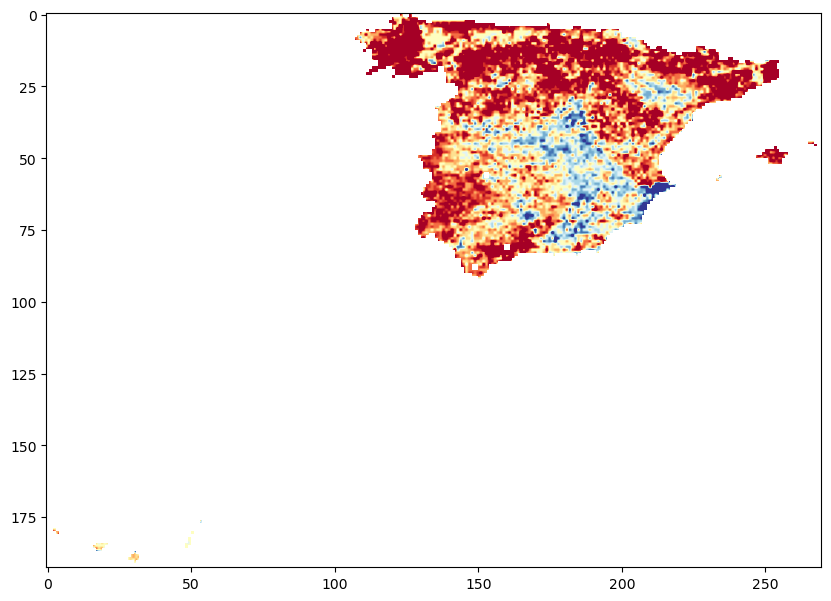

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(diff.stocks.values, cmap='RdYlBu', vmin=-5, vmax=5)

**with `xhistogram`**

In [44]:
bins = np.linspace(-10, 10, 81)
h = histogram(diff.stocks, bins=[bins], dim=['lat', 'lon'])
h

<xarray.DataArray 'histogram_stocks' (stocks_bin: 80)>
dask.array<sum-aggregate, shape=(80,), dtype=int64, chunksize=(80,), chunktype=numpy.ndarray>
Coordinates:
  * stocks_bin  (stocks_bin) float64 -9.875 -9.625 -9.375 ... 9.375 9.625 9.875

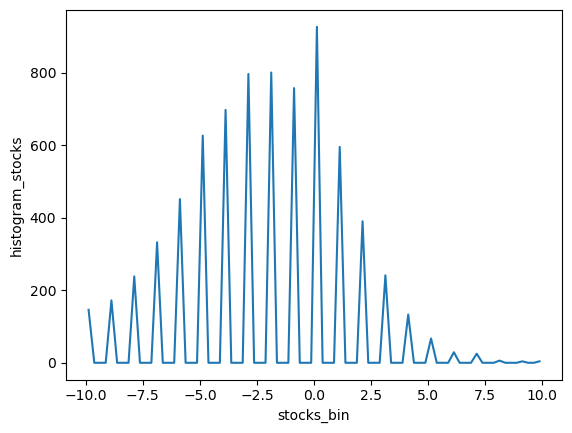

In [45]:
with ProgressBar():
    h.plot()

Plot change distribution

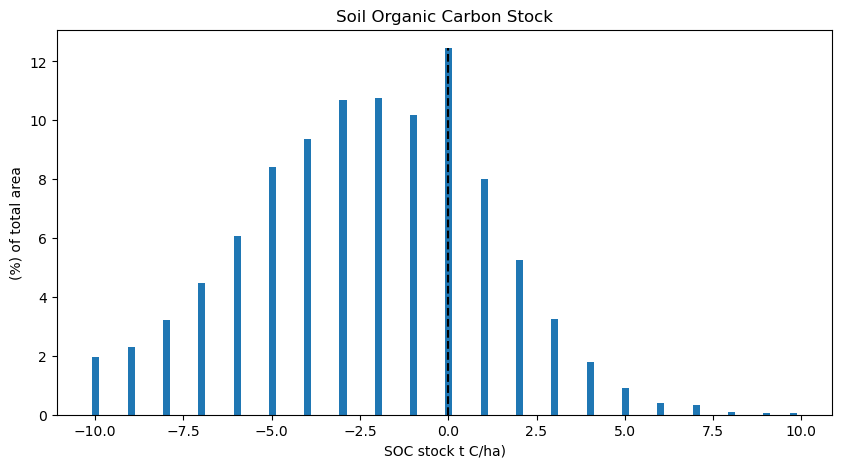

In [46]:
with ProgressBar():
    count = h.values
    
x_min = bins[:-1]
plot_hist(x_min, count)

**with `da.histogram`**

In [47]:
h, bins = da.histogram(diff.stocks, bins=30, range=[0, 30])

Plot change distribution

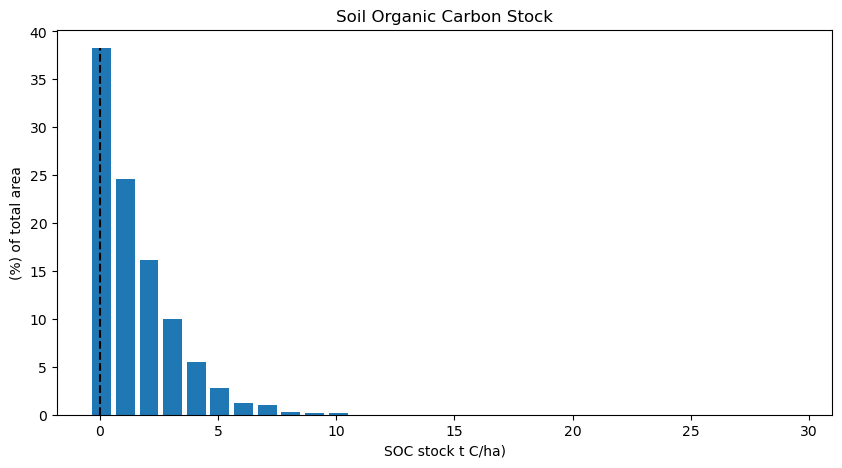

In [48]:
with ProgressBar():
    count = h.compute()

x_min = bins[:-1]
plot_hist(x_min, count)

In [49]:
count/count.sum()*100

array([38.26446281, 24.58677686, 16.11570248,  9.95867769,  5.49586777,
        2.76859504,  1.19834711,  1.03305785,  0.24793388,  0.16528926,
        0.16528926,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

**Display change value**

In [ ]:
years = pd.to_datetime(times[4]).year - pd.to_datetime(times[0]).year
mean_diff = diff.stocks.mean(skipna=True).compute().values
change = mean_diff/years

In [ ]:
mean_diff

In [ ]:
print(f'Soil Organic Carbon Stock Change: {change} t C/ha year')

#### **Entire` DataFrame`**

In [ ]:
%%time
vector_data_new = {}
for name in list(vector_data.keys()):
    print(f'Precalculating change for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_change(df, ds, name, variable='stocks', nBinds=80, bindsRange=[-50, 50])

save_precalculations(vector_data_new, variable = 'stocks', group_type='experimental_dataset', output_type = 'change', root_path = '../data/precalculations/')

**Plot change distribution**

In [ ]:
df = vector_data_new['political_boundaries_1'].copy()
index = 10
count = df['counts'].iloc[index].copy()
bins = df['bins'].iloc[index].copy()
mean_diff = df['mean_diff'].iloc[index].copy()
years = df['years'].iloc[index].copy()
x_min = bins[:-1]
per = count/count.sum()*100
print(f'Soil Organic Carbon Stock Change: {mean_diff/(years[1]-years[0])} t C/ha year')
plot_hist(x_min, count)

### Mean value
#### **Example**

In [33]:
ds_eg = ds.copy()
df = vector_data['political_boundaries_0'].copy()
index = 235
xmin, ymax, xmax, ymin = df.iloc[index]['geometry'].bounds
ds_eg = ds_eg.sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).copy()
ds_mask = create_ds_mask(df.iloc[index:index+1], ds_eg, name='mask', lon_name='lon', lat_name='lat')
ds_eg['mask'] = ds_mask
ds_eg

The mean ds cell area is 5e-06 deg.

Clipped gdf to dataset bounds, giving 1 potential geometries, of which 1 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 1
Number of geoms: 1


<ipython-input-12-95910a6630f0>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Number of ints in mask: 1


<xarray.Dataset>
Dimensions:  (depth: 1, lat: 7095, lon: 9868, time: 5)
Coordinates:
  * depth    (depth) <U4 '0-30'
  * time     (time) datetime64[ns] 2018-12-31 2023-12-31 ... 2038-12-31
  * lon      (lon) float64 -18.15 -18.15 -18.15 -18.15 ... 4.3 4.302 4.304 4.306
  * lat      (lat) float64 43.79 43.79 43.79 43.78 ... 27.65 27.65 27.65 27.64
Data variables:
    stocks   (time, lat, lon) float32 dask.array<chunksize=(1, 70, 584), meta=np.ndarray>
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    crs:            +init=epsg:4326
    descriptions:   ['sum']
    is_tiled:       0
    nodatavals:     [nan]
    offsets:        [0.0]
    res:            [0.002276188236165, 0.002276188236165]
    scales:         [1.0]
    transform:      [0.002276188236165, 0.0, -179.9999999, 0.0, -0.0022761882...

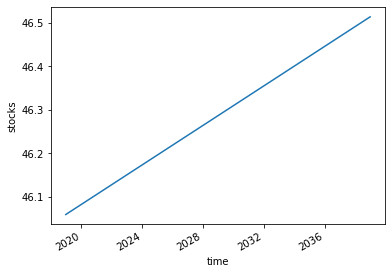

In [34]:
ds_eg.stocks.where(ds_eg['mask'] == index).mean(['lon', 'lat']).plot()

In [ ]:
ds_eg.stocks.where(ds_eg['mask'] == index).mean(['lon', 'lat']).values

In [ ]:
(ds_eg.stocks
.isel(time=slice(0,4))
 .where(ds_eg['mask'] == index)
 .plot.imshow(col='time', col_wrap=4))

#### **Entire` DataFrame`**

In [ ]:
%%time
vector_data_new = {}
for name in list(vector_data.keys()):
    print(f'Precalculating mean values for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_time_series(df, ds, name, variable='stocks')
    
save_precalculations(vector_data_new, variable = 'stocks', group_type='experimental_dataset', output_type = 'time_series', root_path = '../data/precalculations/')

**Plot time series**

In [ ]:
df = vector_data_new['political_boundaries_1'].copy()
index = 10
mean_values = df['mean_values'].iloc[index].copy()
years = df['years'].iloc[index].copy()
plt.plot(years, mean_values)

**Using `groupby`**

In [ ]:
%%time
grouped_xds = ds.groupby(ds['landforms_Plateau'])
grid_mean = grouped_xds.mean().rename({"stocks": "mean"})
grid_mean.to_dataframe()

***
## All the computational process at once
### Experimental, Historic, and Recent datasets
**Input variables**

In [ ]:
#s3_path = 's3://soils-revealed/global-dataset.zarr' #'s3://soils-revealed/experimental-dataset.zarr' 
path = '../data/global-dataset.zarr' #'../data/experimental-dataset.zarr'#
group = 'recent'  #'stocks' #'concentration' #'historic'
variable = 'stocks' #'concentration'  #'stocks'  
iso = None #'ARG'
tolerance = 0.075
group_type = 'recent' #'experimental_dataset'  # 'historic' 
nBinds = [10] #[20] #[80] #[40, 40, 60]   
bindsRange = [[-50,50]]  #[[-10, 10]] #[[-50, 50]], [[-20,20], [-40,40], [-60,60]] 
level=1

**Computation of level 1 geometries**

In [ ]:
# Read xarray.Dataset from Zarr
print('Reading  xarray.Dataset.')
ds = read_dataset_from_zarr_local(path, group)

# Read vector data
print('Reading  vector data.')
vector_data = prepare_vector_data_level(iso=iso, tolerance=tolerance, level=level)

# Change bboxes
if level == 1 and iso == None:
    # Alaska
    vector_data['political_boundaries_1'].at[1707,'bbox'] = '[-179.1506, 51.2097, -125, 72.6875]'
    
names = vector_data.keys()
# Precalculate change distribution
print('Precalculating change distribution.')
vector_data_new = {}
for name in names:
    print(f'Precalculating change for {name}:')
    vector_data_new[name] = precalculate_change_by_geom(vector_data[name], ds, name, variable=variable, group_type=group_type, nBinds=nBinds, bindsRange=bindsRange)

save_precalculations_level1(vector_data_new, variable = variable, group_type=group_type, output_type = 'change', root_path = '../data/precalculations/')

## Precalculate time series
print('Precalculating time series.')
vector_data_new = {}
for name in names:
    print(f'Precalculating mean values for {name}:')
    vector_data_new[name] = precalculate_time_series_by_geom(vector_data[name], ds, name, variable=variable, group=group)
    
save_precalculations_level1(vector_data_new, variable = variable, group_type=group_type, output_type = 'time_series', root_path = '../data/precalculations/')

**Computation of level 0 geometries**

In [ ]:
vector_data_0 = prepare_vector_data_level(iso=iso, tolerance=tolerance, level=0)

In [ ]:
for geom_name in ['political_boundaries', 'landforms', 'biomes', 'hydrological_basins']:
    df_out = compute_level_0_change(geom_name, group_type, variable, vector_data_0)
    df_out.to_csv(f'../data/precalculations/{geom_name}_{group_type}_{variable}_change.csv', index=False)
    df_out = compute_level_0_time_series(geom_name, group_type, variable, vector_data_0)
    df_out.to_csv(f'../data/precalculations/{geom_name}_{group_type}_{variable}_time_series.csv', index=False)

### Future scenarios datasets

In [35]:
group_types = {'crop': ['crop_I', 'crop_MG', 'crop_MGI'],
              'grass': ['grass_full', 'grass_part'],
              'degradation': ['degradation_ForestToCrop', 'degradation_ForestToGrass', 'degradation_NoDeforestation'],
              'rewilding': ['rewilding']}

group = 'future' 
variable = 'stocks' 
iso = None
tolerance = 0.075
level=1
binds = {'crop': [30],
        'grass': [30],
        'degradation': [51],
        'rewilding': [60]}
ranges = {'crop': [[0,30]],
         'grass': [[0,30]],
         'degradation': [[-50,1]],
         'rewilding': [[-30,30]]}

# Read vector data
print('Reading  vector data.')
vector_data = prepare_vector_data_level(iso=iso, tolerance=tolerance, level=level)
vector_data_0 = prepare_vector_data_level(iso=iso, tolerance=tolerance, level=0)

# Change bboxes
if level == 1 and iso == None:
    # Alaska
    vector_data['political_boundaries_1'].at[1707,'bbox'] = '[-179.1506, 51.2097, -125, 72.6875]'
    
for group_key in group_types.keys():
    nBinds = binds[group_key]
    bindsRange = ranges[group_key]
    for group_type in group_types[group_key]:
        print(f'Computing values for {group_type}!')
        path = f'../data/{group_type}.zarr'

        # Read xarray.Dataset from Zarr
        print('Reading  xarray.Dataset.')
        ds = read_dataset_from_zarr_local(path, group)
        
        names = vector_data.keys()
        ## Precalculate change distribution
        print('Precalculating change distribution.')
        vector_data_new = {}
        for name in names:
            print(f'Precalculating change for {name}:')
            vector_data_new[name] = precalculate_change_by_geom(vector_data[name], ds, name, variable=variable, group_type=group_type, nBinds=nBinds, bindsRange=bindsRange)
        
        save_precalculations_level1(vector_data_new, variable = variable, group_type=group_type, output_type = 'change', root_path = '../data/precalculations/')
        
        ## Precalculate time series
        print('Precalculating time series.')
        vector_data_new = {}
        for name in names:
            print(f'Precalculating mean values for {name}:')
            vector_data_new[name] = precalculate_time_series_by_geom(vector_data[name], ds, name, variable=variable, group=group)
            
        save_precalculations_level1(vector_data_new, variable = variable, group_type=group_type, output_type = 'time_series', root_path = '../data/precalculations/')
        
        for geom_name in ['political_boundaries', 'landforms', 'biomes', 'hydrological_basins']:
            df_out = compute_level_0_change(geom_name, group_type, variable, vector_data_0)
            df_out.to_csv(f'../data/precalculations/{geom_name}_{group_type}_{variable}_change.csv', index=False)
            df_out = compute_level_0_time_series(geom_name, group_type, variable, vector_data_0)
            df_out.to_csv(f'../data/precalculations/{geom_name}_{group_type}_{variable}_time_series.csv', index=False)

Reading  vector data.
Reading Political boundaries


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Landforms


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Biomes


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Hydrological basins


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Political boundaries


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Landforms


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Biomes


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Reading Hydrological basins


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Computing values for crop_I!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
Precalculating mean values for hydrological_basins_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Computing values for crop_MG!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for hydrological_basins_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Computing values for crop_MGI!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
Precalculating mean values for hydrological_basins_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Computing values for grass_full!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
Precalculating mean values for hydrological_basins_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Computing values for grass_part!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for hydrological_basins_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Computing values for degradation_ForestToGrass!
Reading  xarray.Dataset.
Precalculating time series.
Precalculating mean values for political_boundaries_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

Precalculating mean values for landforms_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


Precalculating mean values for biomes_1:


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encoun

All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts
<ipython-input-20-2dc543bfa6b5>:37: RuntimeWarning: invalid value encountered in true_divide
  values = sums/counts


All elements of mask are NaN. Try to set 'wrap_lon=True'.
All elements of mask are NaN. Try to set 'wrap_lon=True'.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Merge datasets

In [36]:
dir_path = '../data/precalculations/'
file_list = os.listdir(dir_path)
groups = ['biomes', 'hydrological_basins', 'landforms', 'political_boundaries']
subgroups = ['change', 'time_series']
group_types = ['experimental_dataset', 'historic', 'recent', 'crop_I', 'crop_MG', 'crop_MGI', 'grass_full', 'grass_part', 'degradation_ForestToCrop', 'degradation_ForestToGrass', 'degradation_NoDeforestation', 'rewilding']

for group in groups:
    group_list = [s for s in file_list if group in s]
    group_list = [s for s in group_list if not ('_1_' in s)]
    group_types = ['experimental_dataset', 'historic', 'recent', 'crop_I', 'crop_MG', 'crop_MGI', 'grass_full', 'grass_part', 'degradation_ForestToCrop', 'degradation_ForestToGrass', 'degradation_NoDeforestation', 'rewilding']

    new_file_list = []
    for group_type in group_types:
        new_file_list.append([s for s in group_list if group_type in s])
        
    group_list = [item for l in new_file_list for item in l]
    
    for subgroup in subgroups:
        sub_list = [s for s in group_list if subgroup in s]
        for n, file in enumerate(sub_list):
            if n == 0:
                df = pd.read_csv(dir_path+file, index_col=[0])
                if 'stocks' in file: df.rename(columns={'group': 'group_type'}, inplace=True)
            else:
                df_new = pd.read_csv(dir_path+file, index_col=[0])
                if 'stocks' in file: df_new.rename(columns={'group': 'group_type'}, inplace=True)
                df = pd.concat([df, df_new])
                
        df.to_csv(dir_path+group+'_'+subgroup+'.csv', index=False)
        
#Remove id_0 = 13 in Biomes
for subgroup in ['change', 'time_series']:
    df = pd.read_csv(f'../data/precalculations/biomes_{subgroup}.csv')
    df[df['id_0'] != 13].to_csv(f'../data/precalculations/biomes_{subgroup}.csv')

## All the computational process (old version)

In [ ]:
# Read xarray.Dataset from Zarr
print('Reading  xarray.Dataset.')
ds = read_dataset_from_zarr_local(path, group)

# Read vector data
print('Reading  vector data.')
vector_data = prepare_vector_data(iso=iso, tolerance=tolerance)

# Create the data mask by rasterizing the vector data
print('Rasterizing the vector data.')
names = list(vector_data.keys())
#names.remove('landforms_Dragons-be-here')
for name in names:
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask
    
## Precalculate change distribution
#print('Precalculating change distribution.')
#vector_data_new = {}
#for name in names:
#    print(f'Precalculating change for {name}:')
#    df = vector_data[name].copy()
#    vector_data_new[name] = precalculate_change(df, ds, name, variable=variable, group_type=group_type, nBinds=nBinds, bindsRange=bindsRange)
#
save_precalculations(vector_data_new, variable = variable, group_type=group_type, output_type = 'change', root_path = '../data/precalculations/')

## Precalculate time series
print('Precalculating time series.')
vector_data_new = {}
for name in names:
    print(f'Precalculating mean values for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_time_series(df, ds, name, variable=variable, group=group)
    
save_precalculations(vector_data_new, variable = variable, group_type=group_type, output_type = 'time_series', root_path = '../data/precalculations/')

## Upload precalculations to Carto

In [ ]:
from carto.auth import APIKeyAuthClient
from carto.datasets import DatasetManager
import getpass

**Authentication**

In [ ]:
carto_api_key = getpass.getpass('Carto API Key:')

In [ ]:
USR_BASE_URL = "https://35.233.41.65/user/skydipper/"
auth_client = APIKeyAuthClient(api_key=carto_api_key, base_url=USR_BASE_URL)

**Import local datasets into CARTO via the Import API**

In [ ]:
# write here the path to a local file or remote URL
LOCAL_FILE_OR_URL = "../data/precalculations/biomes_change.csv"

dataset_manager = DatasetManager(auth_client)
dataset = dataset_manager.create(LOCAL_FILE_OR_URL)

In [ ]:
import requests

In [ ]:
query = "SELECT * FROM political_boundaries_time_series WHERE variable = 'stocks' AND depth = '0-30' AND group_type =  'experimental_dataset' AND gid_1 = 'ARG.20_1'"

In [ ]:
#urlCarto = f"https://skydipper.35.233.41.65/api/v2/sql"
urlCarto = f"http://35.233.41.65/user/skydipper/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

In [ ]:
df = gpd.GeoDataFrame(data.get("rows"))

In [ ]:
df

In [ ]:
r.url